# Plant Pathology 2020 - FGVC7

In [59]:
import numpy as np
import pandas as pd

from collections import defaultdict
from hashlib import md5
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import PIL
from tqdm import tqdm
import os
import shutil

import splitfolders

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


## EDA

In [11]:
train_df = pd.read_csv('train.csv')
submit_df = pd.read_csv('test.csv')

In [12]:
train_df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [13]:
train_df.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [14]:
img_dir = Path('./images')
images = list(img_dir.glob('*.jpg'))
print(f'Found: {len(images)} images')

Found: 3642 images


#### Check to see if there are any duplicate images

In [15]:
hash_dict = defaultdict(list)
for image in img_dir.glob('*.jpg'):
    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

3637

In [16]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[WindowsPath('images/Test_1212.jpg'), WindowsPath('images/Test_570.jpg')]
[WindowsPath('images/Test_1407.jpg'), WindowsPath('images/Train_1703.jpg')]
[WindowsPath('images/Test_1691.jpg'), WindowsPath('images/Test_683.jpg')]
[WindowsPath('images/Test_829.jpg'), WindowsPath('images/Train_1505.jpg')]
[WindowsPath('images/Train_1173.jpg'), WindowsPath('images/Train_379.jpg')]


10

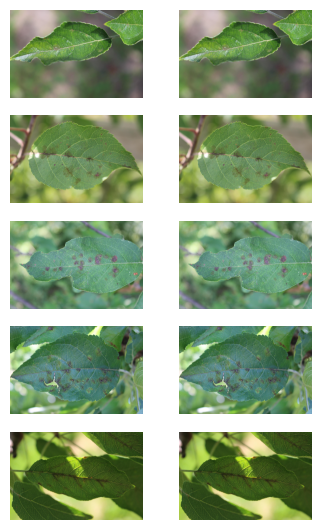

In [17]:
plt.figure(figsize=(4,8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    plt.subplot(6,2, idx+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

#### We cannot delete duplicate images from the test (submission) dataset. We will only delete the duplicate photo from the train dataset

In [18]:
train_df = train_df[train_df.image_id != 'Train_379'].reset_index()
os.remove('./images/Train_379.jpg')

## Analysis of color distribution in Train and Submit datasets

In [19]:
def histogram(df, name):
    red = []; green = []; blue = []
    for i in tqdm(df.index):
        img_path = './images/' + df['image_id'][i] + '.jpg'
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = np.array(img)
        red.append(np.mean(x[0][:,0])); green.append(np.mean(x[0][:,1])); blue.append(np.mean(x[0][:,2]))
    df['redm']= red; df['greenm']= green; df['bluem']= blue

    plt.figure(figsize = (10,5))
    sns.histplot(df.redm.values, bins=80, color='red', alpha=0.3, kde=True)
    sns.histplot(df.greenm.values, bins=80, color='green', alpha=0.3, kde=True)
    sns.histplot(df.bluem.values, bins=80, color='blue', alpha=0.3, kde=True)
    plt.ylabel('Frequency')
    plt.xlabel('Intensity')
    plt.title('Distribution of colors in %s dataset' % name)

100%|██████████| 1820/1820 [00:49<00:00, 37.05it/s]


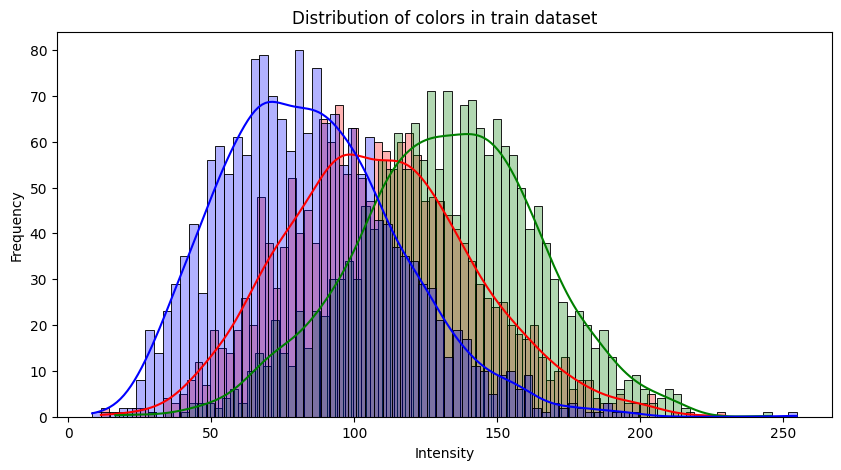

In [20]:
histogram(train_df, 'train')

100%|██████████| 1821/1821 [00:48<00:00, 37.69it/s]


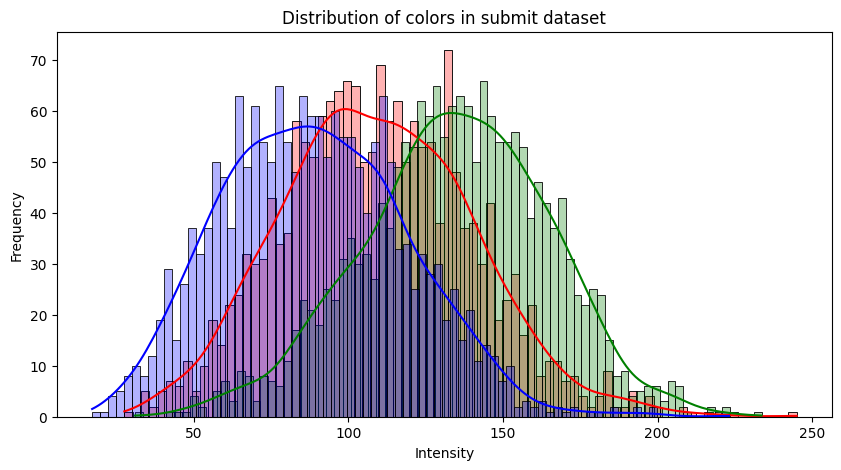

In [21]:
histogram(submit_df, 'submit')

### Both sets of images have a very similar distribution, logically shifted towards green

## Distribution by Category

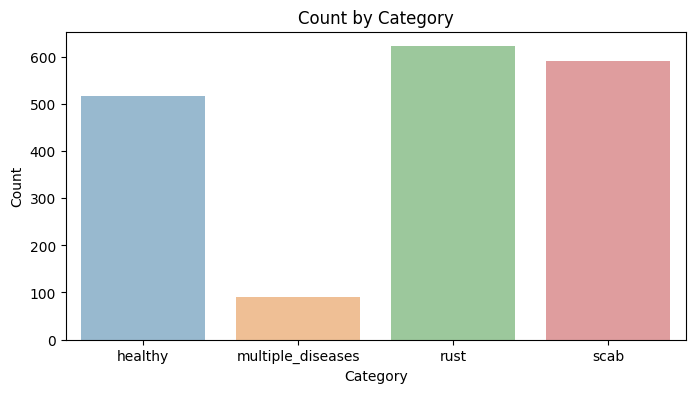

In [22]:
healthy = train_df.healthy.sum()
multiple_diseases = train_df.multiple_diseases.sum()
rust = train_df.rust.sum()
scab = train_df.scab.sum()

data = [['healthy', healthy], ['multiple_diseases', multiple_diseases], ['rust', rust,], ['scab', scab]]
df = pd.DataFrame(data, columns=['category', 'count']) 
#print(df.head())

plt.figure(figsize = (8,4))
sns.barplot(data=df, x='category', y='count', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Count by Category')
plt.show()

## Examples

In [23]:
def showImages(category='healthy'):
    plt.figure(figsize=(8,16))
    count = 1
    for i in train_df[train_df[category] == 1].head(6).index:
        img = train_df.image_id[i] + '.jpg'
        img_path = img_dir / img
        im = PIL.Image.open(img_path)
        plt.subplot(6,2, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
    plt.show()

### Healthy

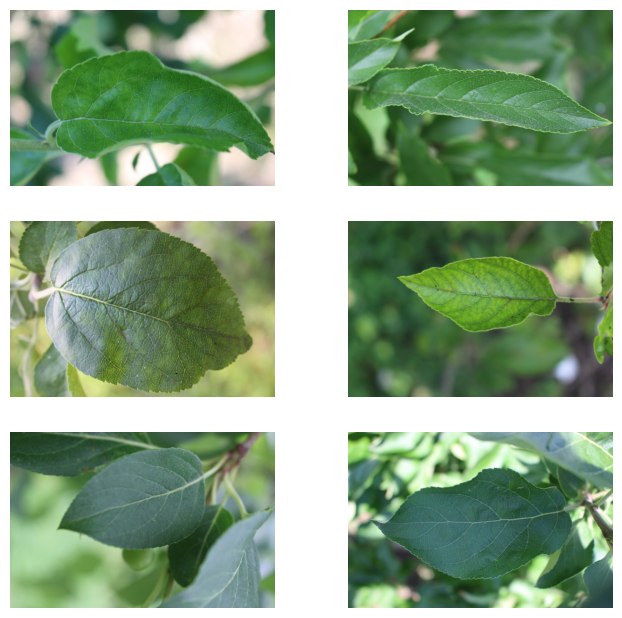

In [24]:
showImages('healthy')

### Multiple diseases

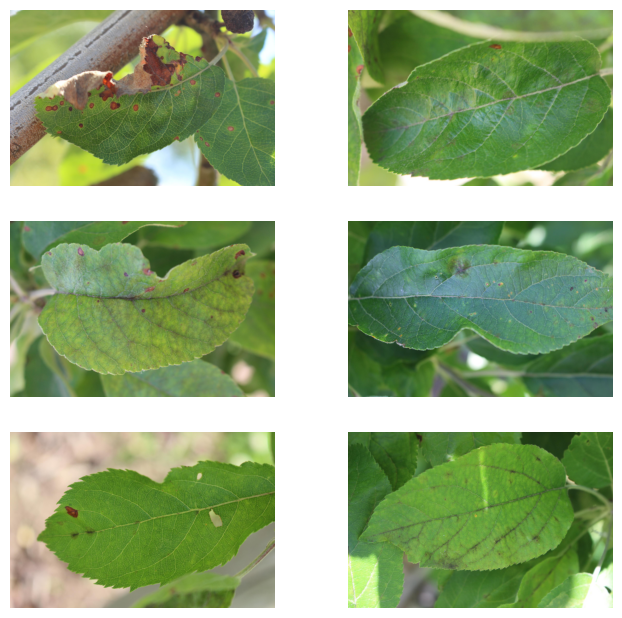

In [25]:
showImages('multiple_diseases')

### Rust

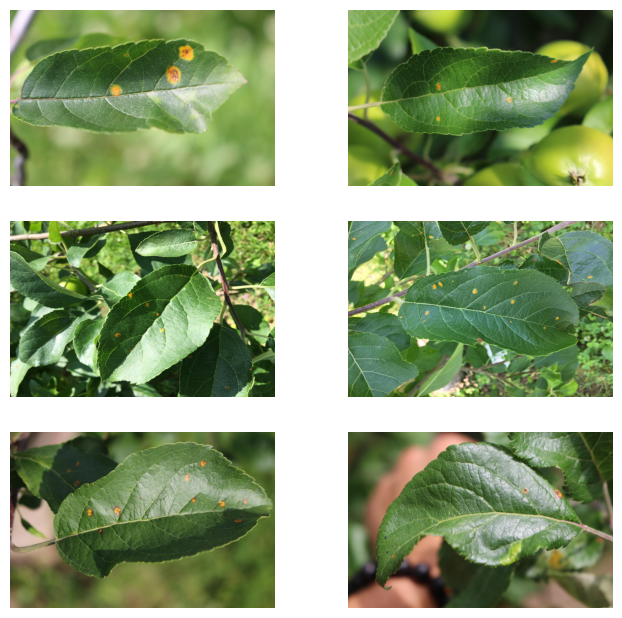

In [26]:
showImages('rust')

### Scab

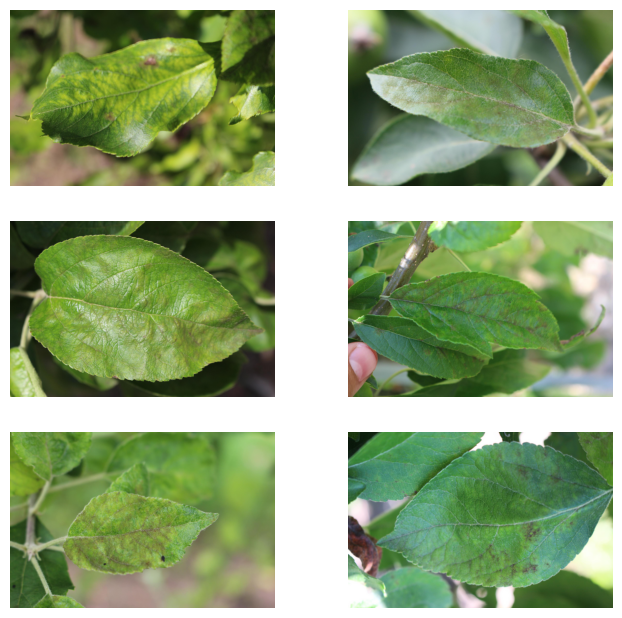

In [27]:
showImages('scab')

## Creating a new folder structure (according to the datasets)
 
#### With /submit and /training
#### /training has its images splitted into train, val, test with a subfolder for each category

### Creating new subfolders...

In [28]:
train_dir = Path('./images/training')
submit_dir = Path('./images/submit')

for label in ['healthy', 'multiple_diseases', 'rust', 'scab']:
    d = train_dir / label
    d.mkdir(parents=True, exist_ok=True)
    
submit_dir.mkdir(parents=True, exist_ok=True)    

### ...and moving the images

In [29]:
count = 0
for i in tqdm(train_df.index):
    img = train_df.image_id[i] + '.jpg'
    img_path = img_dir / img
    for label in ['healthy', 'multiple_diseases', 'rust', 'scab']:
        if train_df[label][i] == 1:
            new_path = train_dir.absolute() / label / img
            shutil.move(img_path, new_path)
            count += 1

print(f'Total moved: {count}')
    

100%|██████████| 1820/1820 [00:01<00:00, 1095.97it/s]

Total moved: 1820


In [30]:
count = 0
for i in tqdm(submit_df.index):
    img = submit_df.image_id[i] + '.jpg'
    img_path = img_dir / img
    new_path = submit_dir / img
    shutil.move(img_path, new_path)
    count += 1
    
print(f'Total moved: {count}')

100%|██████████| 1821/1821 [00:01<00:00, 1343.91it/s]

Total moved: 1821


### Splitting training data into 3 folders (train, val, test)

In [31]:
splitfolders.ratio(train_dir, output='./images/tmp', move=True, ratio=(0.8,0.1,0.1))

shutil.rmtree(train_dir)
os.rename('./images/tmp', train_dir)

Copying files: 1820 files [00:01, 1080.11 files/s]


## Training the model

Functions to preprocess the image and train the model

In [63]:
def preprocess(base_model = 'EfficientNetv2B0'):
    if base_model == 'Xception':
        input_size = 224
        preprocessing_function=tf.keras.applications.xception.preprocess_input
    elif base_model == 'EfficientNetv2B0':
        input_size = 224
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    elif base_model == 'EfficientNetv2B3':
        input_size = 300
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    elif base_model == 'EfficientNetv2B7':
        input_size = 600
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input

    train_gen = ImageDataGenerator(preprocessing_function = preprocessing_function)
    val_gen = ImageDataGenerator(preprocessing_function = preprocessing_function)
    test_gen = ImageDataGenerator(preprocessing_function = preprocessing_function)

    train_ds = train_gen.flow_from_directory(
        './images/training/train',
        target_size=(input_size, input_size),
        batch_size=32
    )
    val_ds = val_gen.flow_from_directory(
        './images/training/val',
        target_size=(input_size, input_size),
        batch_size=32
    )
    test_ds = test_gen.flow_from_directory(
        './images/training/test',
        target_size=(input_size, input_size),
        batch_size=32
    )
    return train_ds, val_ds, test_ds


def make_model(base_model = 'EfficientNetv2B0', learning_rate=0.001, inner_size=100,
               drop_rate=0.5):

    if base_model == 'Xception':
        input_size = 224
        base_model = keras.applications.Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(input_size, input_size, 3)
        )
    elif base_model == 'EfficientNetv2B0':
        input_size = 224
        base_model = keras.applications.EfficientNetV2B0(        
            weights='imagenet',
            include_top=False,
            input_shape=(input_size, input_size, 3)
        )
    elif base_model == 'EfficientNetv2B3':
        input_size = 300
        base_model = keras.applications.EfficientNetV2B3(        
            weights='imagenet',
            include_top=False,
            input_shape=(input_size, input_size, 3)
        )
    elif base_model == 'EfficientNetv2B7':
        input_size = 300
        base_model = keras.applications.EfficientNetV2B7(        
            weights='imagenet',
            include_top=False,
            input_shape=(input_size, input_size, 3)
        )        

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    if inner_size > 0:
      inner = keras.layers.Dense(inner_size, activation='relu')(vectors)
      drop = keras.layers.Dropout(drop_rate)(inner)
    else:
      drop = keras.layers.Dropout(drop_rate)(vectors)
    
    outputs = keras.layers.Dense(4, activation='softmax')(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

## Doing a initial test with several learning rates
We will evaluate 2 different base models under the same initial conditions (image sizes, no internal layers, epochs, etc)

### Using Xception

In [55]:
base_model ='Xception'
inner_size = 0
drop_rate = 0.0
input_size = 224
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)

scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(base_model = base_model, learning_rate=lr, inner_size=inner_size, drop_rate=drop_rate)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    scores[lr] = history.history
print()

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
0.0001
Epoch 1/50
46/46 [==============================] - 118s 2s/step - loss: 1.2637 - accuracy: 0.3531 - val_loss: 1.1825 - val_accuracy: 0.5028
Epoch 2/50
46/46 [==============================] - 121s 3s/step - loss: 1.1353 - accuracy: 0.5079 - val_loss: 1.0972 - val_accuracy: 0.5801
Epoch 3/50
46/46 [==============================] - 111s 2s/step - loss: 1.0581 - accuracy: 0.6105 - val_loss: 1.0411 - val_accuracy: 0.6630
Epoch 4/50
46/46 [==============================] - 114s 2s/step - loss: 1.0024 - accuracy: 0.6435 - val_loss: 0.9983 - val_accuracy: 0.6685
Epoch 5/50
46/46 [==============================] - 114s 2s/step - loss: 0.9574 - accuracy: 0.6676 - val_loss: 0.9639 - val_accuracy: 0.6630
Epoch 6/50
46/46 [==============================] - 115s 2s/step - loss: 0.9214 - accuracy: 0.6710 - val_loss: 0.9364 - val_accuracy: 0.6685
Epoch 7/50
46/46 [=====

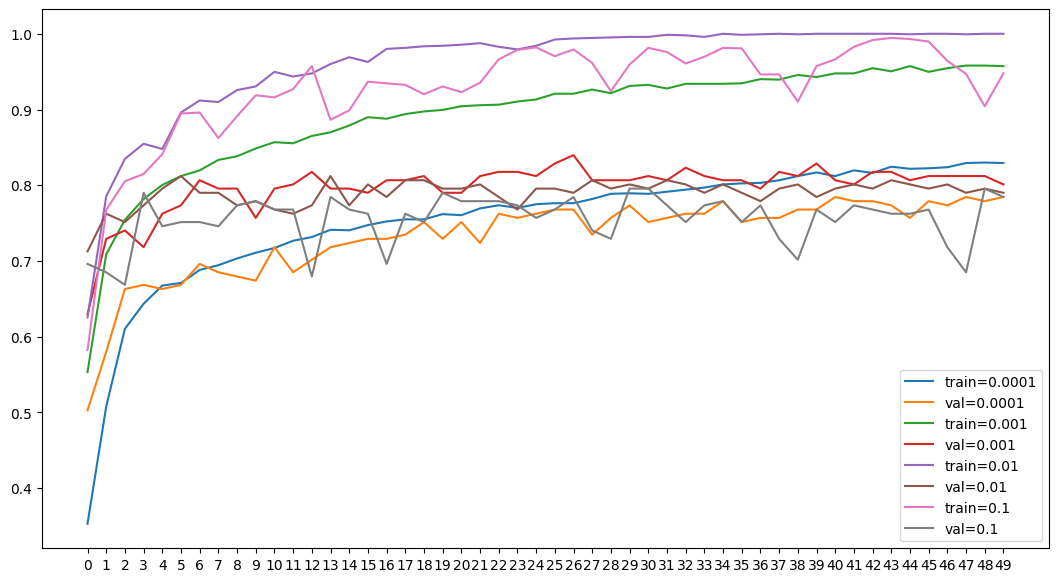

In [56]:
plt.figure(figsize=(13,7))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Using EfficientNetv2

In [41]:
base_model ='EfficientNetv2B0'
inner_size = 0
drop_rate = 0.0
input_size = 224
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)

scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(base_model = base_model, learning_rate=lr, inner_size=inner_size, drop_rate=drop_rate)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    scores[lr] = history.history
    print()

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
0.0001
Epoch 1/50
46/46 [==============================] - 65s 1s/step - loss: 1.2579 - accuracy: 0.4432 - val_loss: 1.1733 - val_accuracy: 0.5635
Epoch 2/50
46/46 [==============================] - 55s 1s/step - loss: 1.0982 - accuracy: 0.6098 - val_loss: 1.0603 - val_accuracy: 0.6519
Epoch 3/50
46/46 [==============================] - 54s 1s/step - loss: 1.0116 - accuracy: 0.6690 - val_loss: 0.9886 - val_accuracy: 0.6906
Epoch 4/50
46/46 [==============================] - 56s 1s/step - loss: 0.9508 - accuracy: 0.6986 - val_loss: 0.9328 - val_accuracy: 0.7348
Epoch 5/50
46/46 [==============================] - 57s 1s/step - loss: 0.9035 - accuracy: 0.7151 - val_loss: 0.8885 - val_accuracy: 0.7348
Epoch 6/50
46/46 [==============================] - 57s 1s/step - loss: 0.8647 - accuracy: 0.7254 - val_loss: 0.8520 - val_accuracy: 0.7459
Epoch 7/50
46/46 [===========

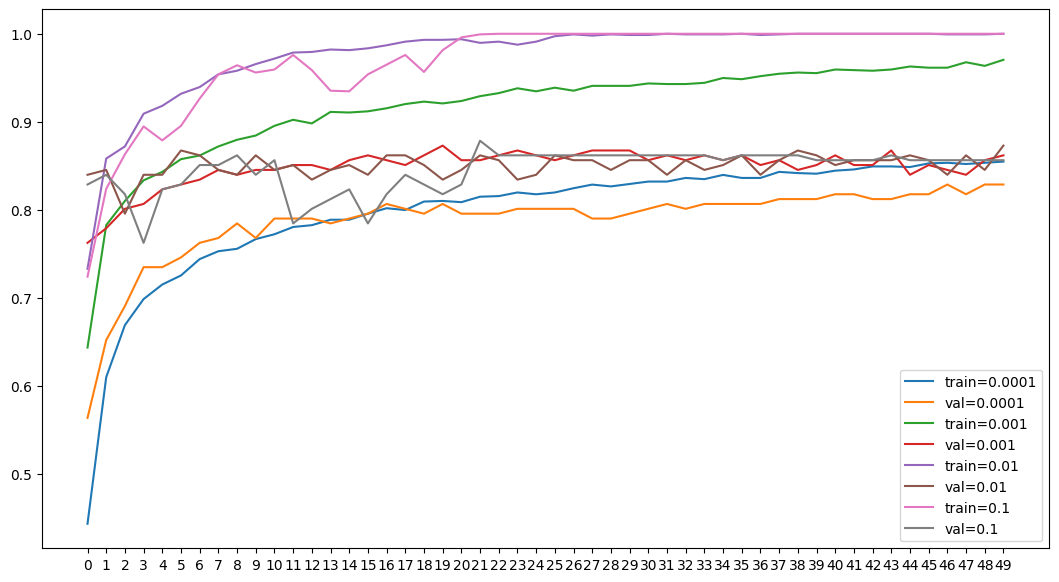

In [52]:
plt.figure(figsize=(13,7))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Findings =>
- *EfficientNetV2* clearly outperforms Xception in both accuracy and training speed
- We select a *learning rate of 0.001* due to its high accuracy and smaller overfitting.

## Adding more layers to the base model

In [53]:
base_model ='EfficientNetv2B0'
learning_rate = 0.001

drop_rate = 0.0
input_size = 224
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)

scores = {}
for inner_size in [10, 100, 1000]:
    print('inner_size: %s' % inner_size)
    model = make_model(base_model=base_model, learning_rate=learning_rate, inner_size=inner_size, drop_rate=drop_rate)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    scores[inner_size] = history.history
    print()

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
inner_size: 10
Epoch 1/50
46/46 [==============================] - 57s 1s/step - loss: 1.0332 - accuracy: 0.5850 - val_loss: 0.8008 - val_accuracy: 0.7072
Epoch 2/50
46/46 [==============================] - 48s 1s/step - loss: 0.6955 - accuracy: 0.7866 - val_loss: 0.6417 - val_accuracy: 0.8066
Epoch 3/50
46/46 [==============================] - 50s 1s/step - loss: 0.5859 - accuracy: 0.8266 - val_loss: 0.5978 - val_accuracy: 0.8232
Epoch 4/50
46/46 [==============================] - 57s 1s/step - loss: 0.5142 - accuracy: 0.8417 - val_loss: 0.5530 - val_accuracy: 0.8287
Epoch 5/50
46/46 [==============================] - 55s 1s/step - loss: 0.4637 - accuracy: 0.8541 - val_loss: 0.5241 - val_accuracy: 0.8398
Epoch 6/50
46/46 [==============================] - 48s 1s/step - loss: 0.4309 - accuracy: 0.8617 - val_loss: 0.5173 - val_accuracy: 0.8453
Epoch 7/50
46/46 [===

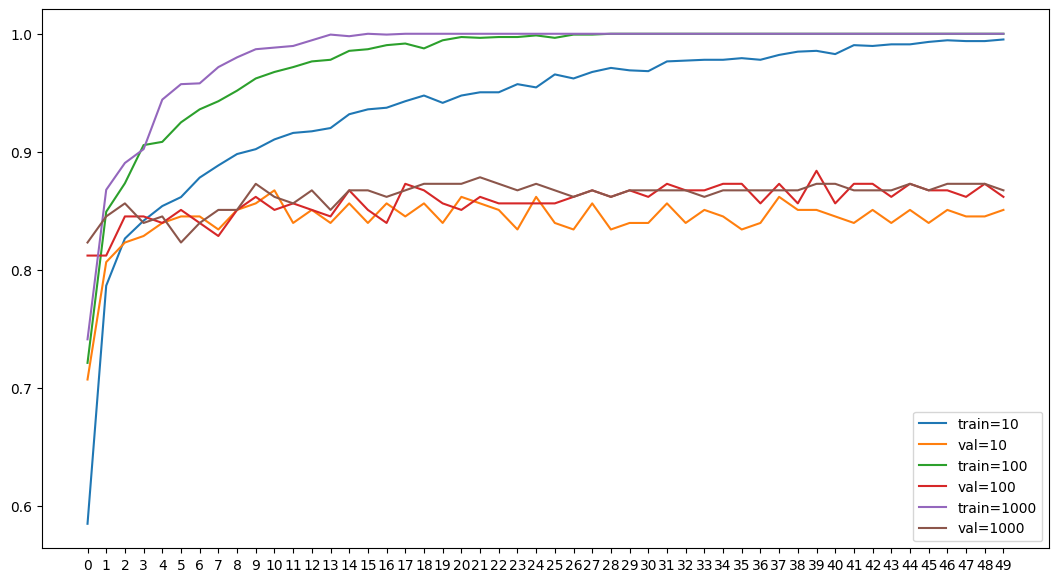

In [54]:
plt.figure(figsize=(13,7))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Findings =>
- Adding more inner layers seems to make overfitting worse without improving accuracy. Therefore we choose *inner_size = 0*

## Regularization and dropout

In [57]:
base_model ='EfficientNetv2B0'
learning_rate = 0.001
inner_size = 0

input_size = 224
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)

scores = {}
for drop_rate in [0.0, 0.2, 0.5, 0.8]:
    print('drop_rate: %s' % drop_rate)
    model = make_model(base_model=base_model, learning_rate=learning_rate, inner_size=inner_size, drop_rate=drop_rate)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    scores[drop_rate] = history.history
    print()

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
drop_rate: 0.0
Epoch 1/50
46/46 [==============================] - 79s 2s/step - loss: 0.9704 - accuracy: 0.6476 - val_loss: 0.7329 - val_accuracy: 0.7459
Epoch 2/50
46/46 [==============================] - 49s 1s/step - loss: 0.6851 - accuracy: 0.7715 - val_loss: 0.6316 - val_accuracy: 0.7790
Epoch 3/50
46/46 [==============================] - 48s 1s/step - loss: 0.5893 - accuracy: 0.8121 - val_loss: 0.5702 - val_accuracy: 0.7956
Epoch 4/50
46/46 [==============================] - 49s 1s/step - loss: 0.5330 - accuracy: 0.8293 - val_loss: 0.5393 - val_accuracy: 0.8066
Epoch 5/50
46/46 [==============================] - 50s 1s/step - loss: 0.4940 - accuracy: 0.8390 - val_loss: 0.5185 - val_accuracy: 0.8011
Epoch 6/50
46/46 [==============================] - 50s 1s/step - loss: 0.4598 - accuracy: 0.8513 - val_loss: 0.4984 - val_accuracy: 0.8232
Epoch 7/50
46/46 [===

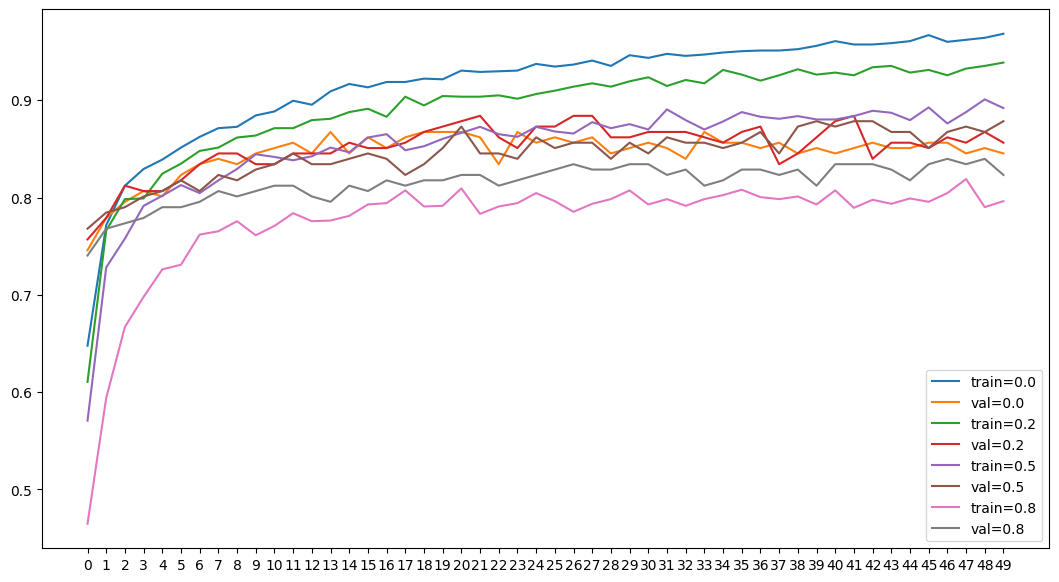

In [58]:
plt.figure(figsize=(13,7))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Findings =>
- We choose a *Dropout rate of 0.5* because it offers the best accuracy vs overfit ratio

## Data augmentation
We will apply a standard set of modifications to the train dataset images

In [70]:
def preprocess_dataAug(base_model = 'EfficientNetv2B0'):
    if base_model == 'Xception':
        input_size = 224
        preprocessing_function=tf.keras.applications.xception.preprocess_input
    elif base_model == 'EfficientNetv2B0':
        input_size = 224
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    elif base_model == 'EfficientNetv2B3':
        input_size = 300
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    elif base_model == 'EfficientNetv2B7':
        input_size = 600
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input

    train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        preprocessing_function=preprocessing_function
    )
    val_gen = ImageDataGenerator(preprocessing_function = preprocessing_function)
    test_gen = ImageDataGenerator(preprocessing_function = preprocessing_function)

    train_ds = train_gen.flow_from_directory(
        './images/training/train',
        target_size=(input_size, input_size),
        batch_size=32
    )
    val_ds = val_gen.flow_from_directory(
        './images/training/val',
        target_size=(input_size, input_size),
        batch_size=32
    )
    test_ds = test_gen.flow_from_directory(
        './images/training/test',
        target_size=(input_size, input_size),
        batch_size=32
    )
    return train_ds, val_ds, test_ds


In [71]:
base_model ='EfficientNetv2B0'
learning_rate = 0.001
inner_size = 0
drop_rate = 0.5

input_size = 224
epochs = 50

train_ds, val_ds, test_ds = preprocess_dataAug(base_model = base_model)
model = make_model(base_model=base_model, learning_rate=learning_rate, inner_size=inner_size, drop_rate=drop_rate)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
Epoch 1/50
46/46 [==============================] - 94s 2s/step - loss: 1.1412 - accuracy: 0.4990 - val_loss: 0.8880 - val_accuracy: 0.6243
Epoch 2/50
46/46 [==============================] - 88s 2s/step - loss: 0.8875 - accuracy: 0.6566 - val_loss: 0.7458 - val_accuracy: 0.7403
Epoch 3/50
46/46 [==============================] - 76s 2s/step - loss: 0.7841 - accuracy: 0.7213 - val_loss: 0.6688 - val_accuracy: 0.7901
Epoch 4/50
46/46 [==============================] - 77s 2s/step - loss: 0.7522 - accuracy: 0.7357 - val_loss: 0.6667 - val_accuracy: 0.7845
Epoch 5/50
46/46 [==============================] - 77s 2s/step - loss: 0.6883 - accuracy: 0.7529 - val_loss: 0.6150 - val_accuracy: 0.8066
Epoch 6/50
46/46 [==============================] - 75s 2s/step - loss: 0.6791 - accuracy: 0.7681 - val_loss: 0.5875 - val_accuracy: 0.8066
Epoch 7/50
46/46 [==================

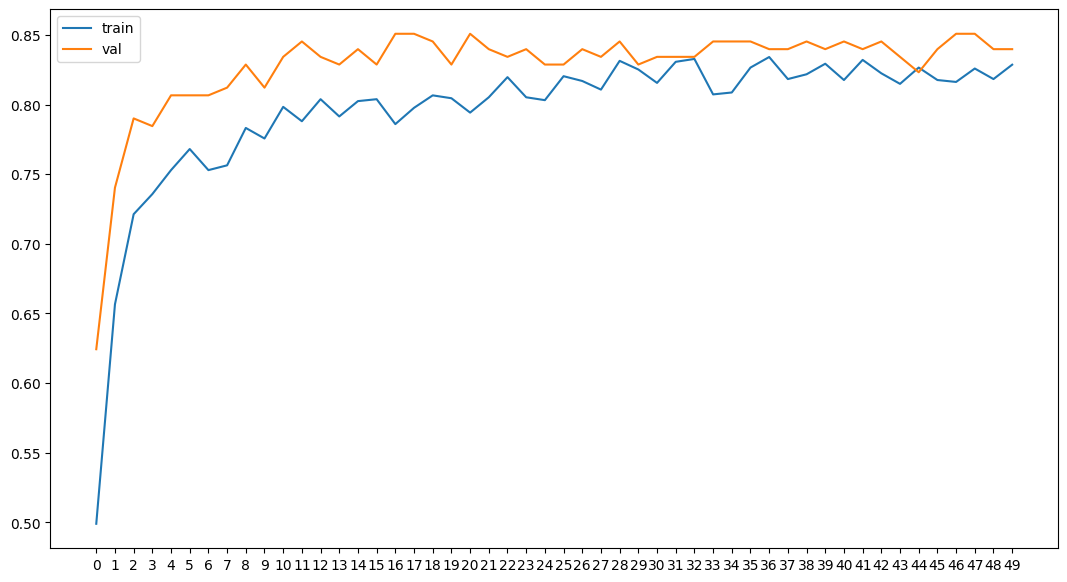

In [72]:
plt.figure(figsize=(13,7))
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='val')
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Findings =>
- It seems that Data Augmentation on our set of images does not manage to improve results

## Training a larger model
We will train EfficientNetV2B3 (image_size = 300 x 300)

In [64]:
base_model ='EfficientNetv2B3'
learning_rate = 0.001
inner_size = 0
drop_rate = 0.5

input_size = 300
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)
model = make_model(base_model=base_model, learning_rate=learning_rate, inner_size=inner_size, drop_rate=drop_rate)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
Epoch 1/50
46/46 [==============================] - 177s 4s/step - loss: 1.0126 - accuracy: 0.5719 - val_loss: 0.7356 - val_accuracy: 0.7735
Epoch 2/50
46/46 [==============================] - 161s 3s/step - loss: 0.6957 - accuracy: 0.7639 - val_loss: 0.6131 - val_accuracy: 0.8232
Epoch 3/50
46/46 [==============================] - 158s 3s/step - loss: 0.5962 - accuracy: 0.8032 - val_loss: 0.5533 - val_accuracy: 0.8232
Epoch 4/50
46/46 [==============================] - 161s 3s/step - loss: 0.5448 - accuracy: 0.8149 - val_loss: 0.5182 - val_accuracy: 0.8453
Epoch 5/50
46/46 [==============================] - 155s 3s/step - loss: 0.5102 - accuracy: 0.8390 - val_loss: 0.4949 - val_accuracy: 0.8508
Epoch 6/50
46/46 [==============================] - 156s 3s/step - loss: 0.4765 - accuracy: 0.8458 - val_loss: 0.4803 - val_accuracy: 0.8508
Epoch 7/50
46/46 [============

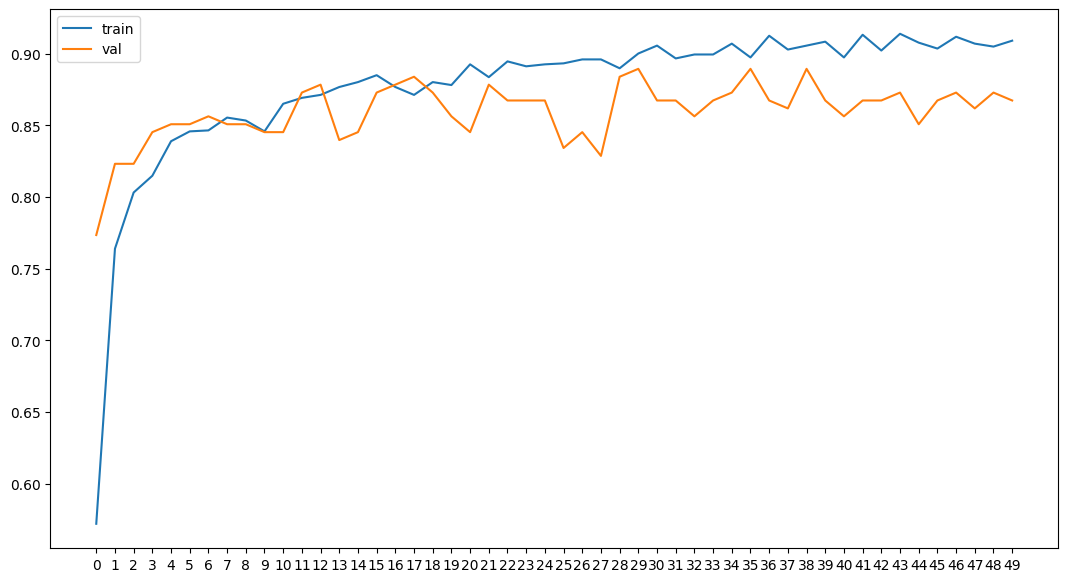

In [66]:
plt.figure(figsize=(13,7))
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='val')
plt.xticks(np.arange(50))
plt.legend()
plt.show()

### Findings =>
- We have managed to improve accuracy very slightly (+2%) at the cost of a larger model size and training time
#### Since the accuracy and overfitting level are good enough, we choose this model for deployment

## Checkpointing and validating the best model

In [74]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [75]:
base_model ='EfficientNetv2B3'
learning_rate = 0.001
inner_size = 0
drop_rate = 0.5

input_size = 300
epochs = 50

train_ds, val_ds, test_ds = preprocess(base_model = base_model)
model = make_model(base_model=base_model, learning_rate=learning_rate, inner_size=inner_size, drop_rate=drop_rate)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint])

Found 1453 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
Epoch 1/50
46/46 [==============================] - 245s 5s/step - loss: 1.0290 - accuracy: 0.5781 - val_loss: 0.7601 - val_accuracy: 0.7624
Epoch 2/50
46/46 [==============================] - 210s 5s/step - loss: 0.7210 - accuracy: 0.7619 - val_loss: 0.6290 - val_accuracy: 0.8011
Epoch 3/50
46/46 [==============================] - 204s 4s/step - loss: 0.6109 - accuracy: 0.8073 - val_loss: 0.5708 - val_accuracy: 0.7956
Epoch 4/50
46/46 [==============================] - 198s 4s/step - loss: 0.5484 - accuracy: 0.8245 - val_loss: 0.5327 - val_accuracy: 0.8066
Epoch 5/50
46/46 [==============================] - 195s 4s/step - loss: 0.5136 - accuracy: 0.8300 - val_loss: 0.4982 - val_accuracy: 0.8453
Epoch 6/50
46/46 [==============================] - 192s 4s/step - loss: 0.4821 - accuracy: 0.8383 - val_loss: 0.4867 - val_accuracy: 0.8066
Epoch 7/50
46/46 [============

In [78]:
# Loading the model
model_file = 'model.h5'
model = tf.keras.models.load_model(model_file)

In [79]:
print('Evaluating with Validation dataset...')                   
eval = model.evaluate(val_ds)
print('Loss : ' + str(eval[0]))
print('Accuracy : ' + str(eval[1]))

Evaluating with Validation dataset...
6/6 [==============================] - 26s 4s/step - loss: 0.3786 - accuracy: 0.8950
Loss : 0.3785598874092102
Accuracy : 0.8950276374816895


In [80]:
print('Evaluating with Test dataset...')                   
eval = model.evaluate(test_ds)
print('Loss : ' + str(eval[0]))
print('Accuracy : ' + str(eval[1]))

Evaluating with Test dataset...
6/6 [==============================] - 22s 4s/step - loss: 0.4848 - accuracy: 0.8118
Loss : 0.48481667041778564
Accuracy : 0.8118279576301575
